## Elbow Method

In [49]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import seaborn as sns
from scipy.stats import boxcox
import calendar
from sklearn.pipeline import Pipeline

In [50]:
pd.set_option('display.max_columns',None)

### Method to load dataset

In [51]:
updated_columns = ['customer_id', 'purchase_date', 'is_local', 'age', 'gender', 'mobile_model', 'price',
                   'is_from_facebook_page', 'is_facebook_page_follower', 'is_returning_customer',
                   'awareness_through_marketing']

def get_data_frame(apply_price_transformation:bool = False,
                   is_returning_customer_dependent_variable:bool = False)->pd.DataFrame:
    """
    Loads data from CSV file into DataFrame and returns the same.
    :return: DataFrame holding data from CSV file
    """
    dataset = pd.read_csv('TechCorner_Sales_update.csv')
    dataset.columns = updated_columns

    # Date Handling
    dataset['purchase_date'] = pd.to_datetime(dataset['purchase_date'], errors='raise', dayfirst=True)

    # Periodic Features
    dataset['day_of_year'] = dataset['purchase_date'].dt.dayofyear

    # Check leap year (366 days if leap year, else 365)
    dataset['year'] = dataset['purchase_date'].dt.year
    dataset['days_in_year'] = dataset['year'].apply(lambda x: 366 if calendar.isleap(x) else 365)

    # sine/cosine transformations
    dataset['sin_day_of_year'] = np.sin(2*np.pi*dataset['day_of_year']/dataset['days_in_year'])
    dataset['cos_day_of_year'] = np.cos(2 * np.pi * dataset['day_of_year'] / dataset['days_in_year'])

    # Drop purchase date column
    dataset.drop(columns=['customer_id', 'purchase_date', 'year', 'days_in_year'], inplace=True)


    # map yes/no to 1/0, instead of performing one hot encoding
    dataset['is_local'] = dataset['is_local'].map({'Rangamati Sadar':1, 'Inside Rangamati':1, 'Outside Rangamati':0})
    dataset['gender'] = dataset['gender'].map({'F':1, 'M':0})
    dataset['is_from_facebook_page'] = dataset['is_from_facebook_page'].map({'Yes':1, 'No':0})
    dataset['is_facebook_page_follower'] = dataset['is_facebook_page_follower'].map({'Yes':1, 'No':0})
    dataset['is_returning_customer'] = dataset['is_returning_customer'].map({'Yes':1, 'No':0})
    dataset['awareness_through_marketing'] = dataset['awareness_through_marketing'].map({'Yes':1, 'No':0})

    if apply_price_transformation:
        dataset['price'], lambda_bc = boxcox(dataset['price'])

    last_column = ['is_from_facebook_page']
    if is_returning_customer_dependent_variable:
        last_column = ['is_returning_customer']

    columns_at_start = ["age", "price", "mobile_model"]
    re_ordered_columns = (columns_at_start +
                          [col for col in dataset.columns if col not in columns_at_start + last_column] +
                          last_column)

    dataset = dataset[re_ordered_columns]
    return dataset

In [52]:
def get_pre_processor()->ColumnTransformer:
    """
    Returns ColumnTransformer encompassing OneHotEncoder and scaler(s)
    :return: Insatance of ColumnTransformer
    """
    # Apply Standard/Robust Scaling & OneHotEncoding
    standard_scaling_features = [0] # Age
    robust_scaling_features = [1] # Price
    categorical_features = [2] # Mobile Model

    return ColumnTransformer([
        ('standardscaler', StandardScaler(), standard_scaling_features)
        , ('robustscaler', RobustScaler(), robust_scaling_features)
        ,('onehotencoder', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ], remainder='passthrough')

In [53]:
# Load data set
dataset = get_data_frame(False, True)
print(dataset.head())
# Perform scaling and one hot encoding. Remove day_of_year as we already have sin/cos transformations
transformed_dataset = get_pre_processor().fit_transform(dataset.drop(columns=['day_of_year']))
transformed_dataset[0:5, :]

   age    price             mobile_model  is_local  gender  \
0   49  17073.0      Galaxy A55 5G 8/128         1       1   
1   44  15546.0  Redmi Note 12 Pro 8/128         1       0   
2   45  26516.0      R-70 Turbo 5G 6/128         1       0   
3   46  21927.0      R-70 Turbo 5G 6/128         1       0   
4   27  16718.0        Vivo T3x 5G 8/128         0       1   

   is_from_facebook_page  is_facebook_page_follower  \
0                      0                          1   
1                      1                          0   
2                      1                          0   
3                      0                          0   
4                      1                          0   

   awareness_through_marketing  day_of_year  sin_day_of_year  cos_day_of_year  \
0                            1          148         0.565345        -0.824855   
1                            1          148         0.565345        -0.824855   
2                            1          148         0

array([[ 1.558891  , -0.55456624,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         1.        ,  0.        ,  1.        ,  1.        ,  0.56534467,
        -0.82485477,  0.        ],
       [ 1.03762713, -0.73829864,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  1.        ,  0.        ,  1.        ,  0.56534467,
        -0.82485477,  0.        ],
       [ 1.1418799 ,  0.58163879,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  0.    

### Build WCSS and Silhouette scores

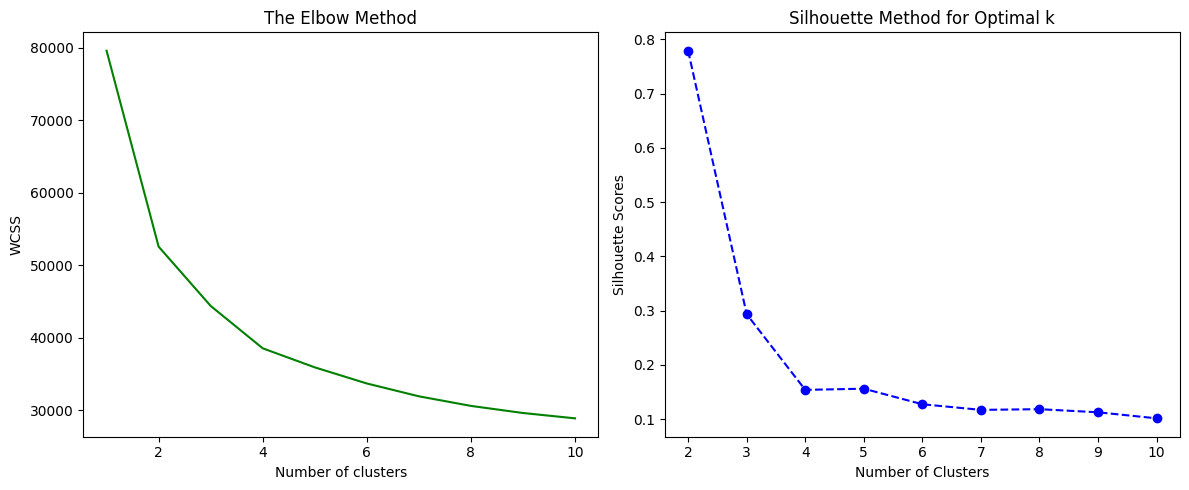

In [54]:
wcss = []
silhouette_scores = []
for i in range(1,11):
    kmeans = KMeans(i, init='k-means++', n_init=10)
    labels = kmeans.fit_predict(transformed_dataset)
    wcss.append(kmeans.inertia_)

    if i != 1:
      silhouette_scores.append(silhouette_score(transformed_dataset, labels))

fig, axes = plt.subplots(1, 2, figsize=(12,5))

# Plot 1
axes[0].plot(range(1,11), wcss, color='g')
axes[0].set_title('The Elbow Method')
axes[0].set_xlabel('Number of clusters')
axes[0].set_ylabel('WCSS')
# Plot 2
axes[1].plot(range(2,11), silhouette_scores, marker="o", linestyle='--', color='b')
axes[1].set_xlabel('Number of Clusters')
axes[1].set_ylabel('Silhouette Scores')
axes[1].set_title("Silhouette Method for Optimal k")

# Adjust layout and show plot
plt.tight_layout()
plt.show()

The Elbow method suggests ideal number of clusters as 4. Though the Silhouette score is less for 4 clusters we kind of proceeded with 4 clusters as suggested by Elbow method  

## Cluster Analysis

In [55]:
dataset.head()

,age,price,mobile_model,is_local,gender,is_from_facebook_page,is_facebook_page_follower,awareness_through_marketing,day_of_year,sin_day_of_year,cos_day_of_year,is_returning_customer
0,49,17073.0,Galaxy A55 5G 8/128,1,1,0,1,1,148,0.565345,-0.824855,0
1,44,15546.0,Redmi Note 12 Pro 8/128,1,0,1,0,1,148,0.565345,-0.824855,0
2,45,26516.0,R-70 Turbo 5G 6/128,1,0,1,0,1,148,0.565345,-0.824855,0
3,46,21927.0,R-70 Turbo 5G 6/128,1,0,0,0,1,148,0.565345,-0.824855,0
4,27,16718.0,Vivo T3x 5G 8/128,0,1,1,0,1,148,0.565345,-0.824855,0


In [59]:
# Apply Standard/Robust Scaling & OneHotEncoding
pipeline = Pipeline([('preprocessor', get_pre_processor()),
                     ('kmeans_model', KMeans(4, init='k-means++', n_init=10, random_state=42))])

# Fit pipeline on dataset.Remove day_of_year as we already have sin/cos transformations
pipeline.fit(dataset.drop(columns=['day_of_year']))

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(), [0]),
                                                 ('robustscaler',
                                                  RobustScaler(), [1]),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  [2])])),
                ('kmeans_model',
                 KMeans(n_clusters=4, n_init=10, random_state=42))])

In [61]:
# Populate cluster details to analyze clusters
kmeans_model = pipeline.named_steps['kmeans_model']
dataset['cluster'] = kmeans_model.labels_
dataset

,age,price,mobile_model,is_local,gender,is_from_facebook_page,is_facebook_page_follower,awareness_through_marketing,day_of_year,sin_day_of_year,cos_day_of_year,is_returning_customer,cluster
0,49,17073.0,Galaxy A55 5G 8/128,1,1,0,1,1,148,0.565345,-0.824855,0,0
1,44,15546.0,Redmi Note 12 Pro 8/128,1,0,1,0,1,148,0.565345,-0.824855,0,0
2,45,26516.0,R-70 Turbo 5G 6/128,1,0,1,0,1,148,0.565345,-0.824855,0,0
3,46,21927.0,R-70 Turbo 5G 6/128,1,0,0,0,1,148,0.565345,-0.824855,0,0
4,27,16718.0,Vivo T3x 5G 8/128,0,1,1,0,1,148,0.565345,-0.824855,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8866,34,21682.0,iQOO Neo 9 Pro 5G 12/256,0,0,1,1,1,81,0.984474,0.175531,1,0
8867,48,26493.0,Moto G85 5G 8/128,1,0,0,0,0,81,0.984474,0.175531,0,0
8868,30,16184.0,Galaxy M35 5G 8/128,1,1,0,0,0,81,0.984474,0.175531,0,2
8869,22,16663.0,Galaxy A55 5G 8/128,1,1,1,0,1,81,0.984474,0.175531,0,2


### Cluster Visualization using PCA

In [64]:
# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(transformed_dataset)

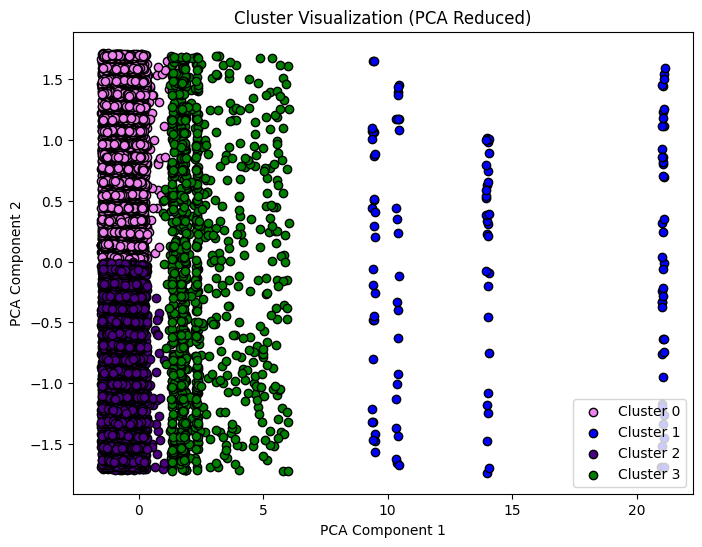

In [65]:
# scatter plot

# Define colors for clusters
colors = ["violet", "blue", "indigo" , "green"]

plt.figure(figsize=(8,6))
for cluster in range(4):
  subset = X_pca[dataset['cluster'] == cluster]
  plt.scatter(subset[:, 0], subset[:, 1], color=colors[cluster], label=f'Cluster {cluster}', edgecolors='k')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Cluster Visualization (PCA Reduced)')
plt.legend()
plt.show()

### Cluster Summary for Numerical Variables

In [66]:
dataset.groupby('cluster').agg({'age':['mean', 'min', 'max'], 'price':['mean', 'min', 'max'],
                                'day_of_year':['mean', 'min', 'max']})

age                  price                     day_of_year      \
              mean min max           mean       min       max        mean min   
cluster                                                                         
0        42.223968  34  50   20478.430454   12702.0   35134.0  197.190778   1   
1        35.040323  18  50  146843.830645  103000.0  200465.0  186.782258   5   
2        25.578104  18  34   20491.176687   12707.0   35735.0  199.892098   1   
3        33.906155  18  50   45705.110999   33068.0   74981.0  199.602422   1   

              
         max  
cluster       
0        366  
1        360  
2        366  
3        366

We can see cluster 0 and 2 are in same price range(12k-35k), and the differentiating factor between those clusters is age. cluster 2 got age range from 18-34 where as age range in cluster 0 is 34-50. We can clearly see that Price is differentiating factor between cluster 1 (high price range), cluster 3 (medium price range) and cluster group 0 & 2 (starting price range).

### Age distribution across clusters

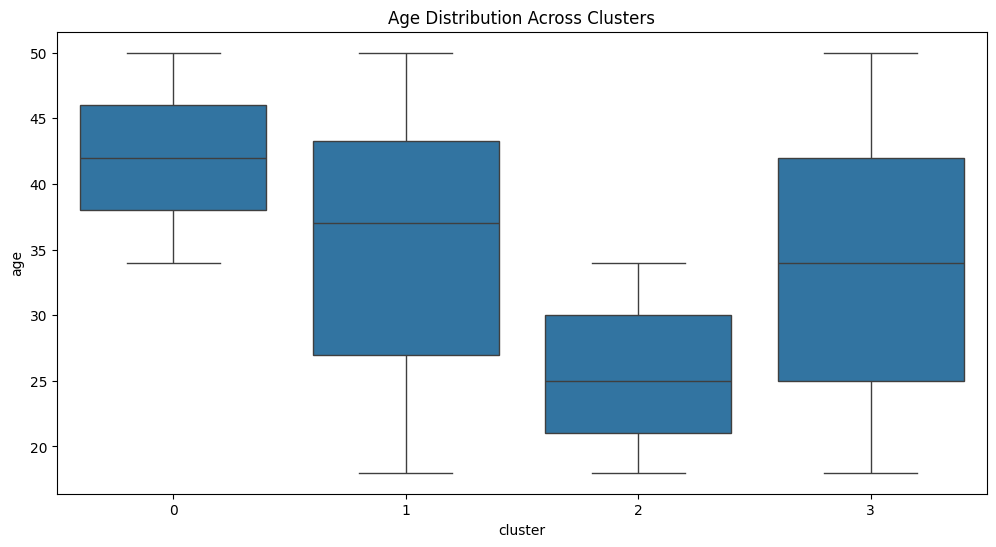

In [67]:
plt.figure(figsize=(12,6))
sns.boxplot(x='cluster', y='age', data=dataset)
plt.title('Age Distribution Across Clusters')
plt.show()

### Price distribution across clusters

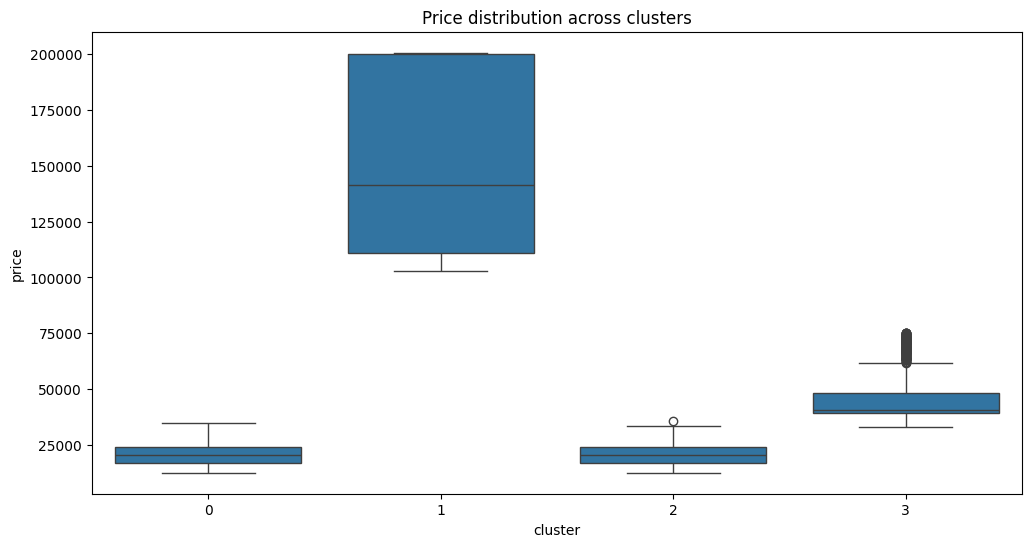

In [68]:
plt.figure(figsize=(12,6))
sns.boxplot(x='cluster', y='price', data=dataset)
plt.title('Price distribution across clusters')
plt.show()

### Purchase day distribution across clusters

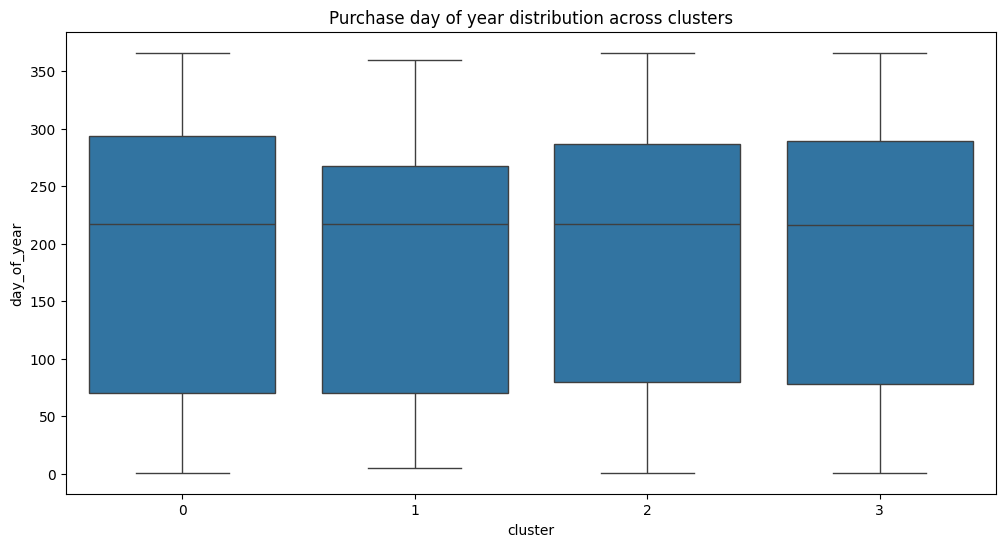

In [69]:
plt.figure(figsize=(12,6))
sns.boxplot(x='cluster', y='day_of_year', data=dataset)
plt.title('Purchase day of year distribution across clusters')
plt.show()

### Categorical Features distribution across clusters

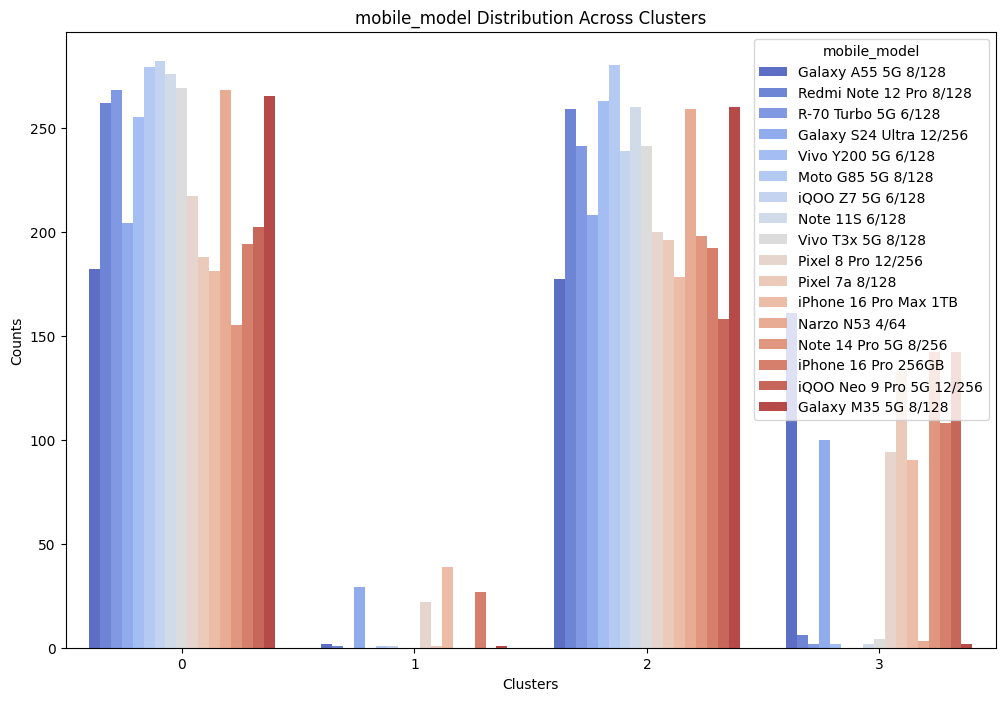

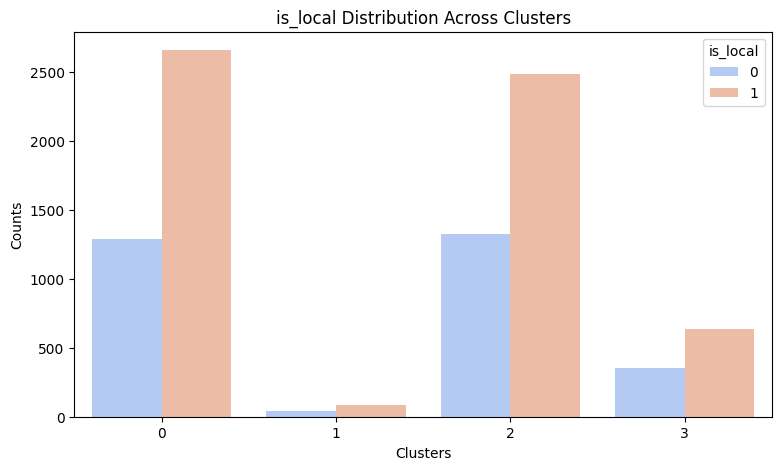

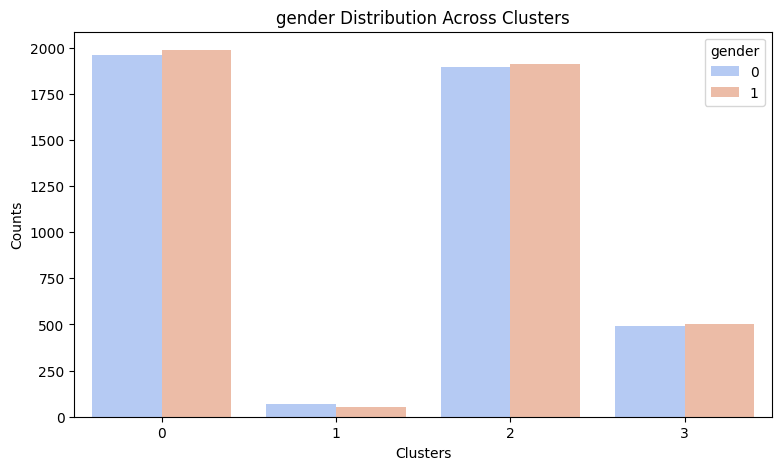

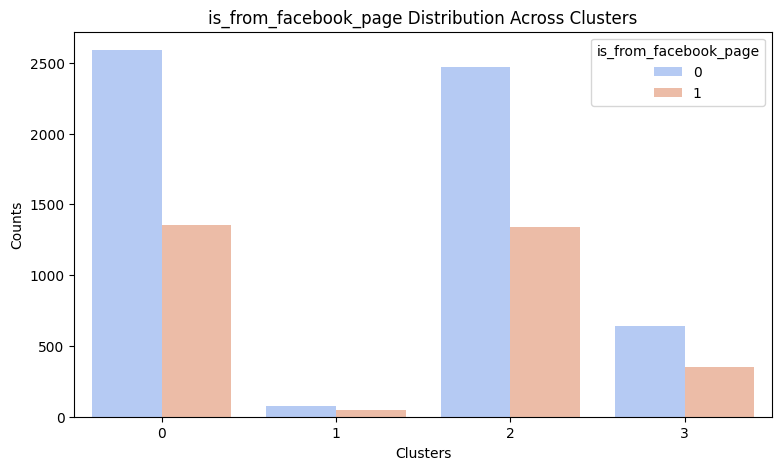

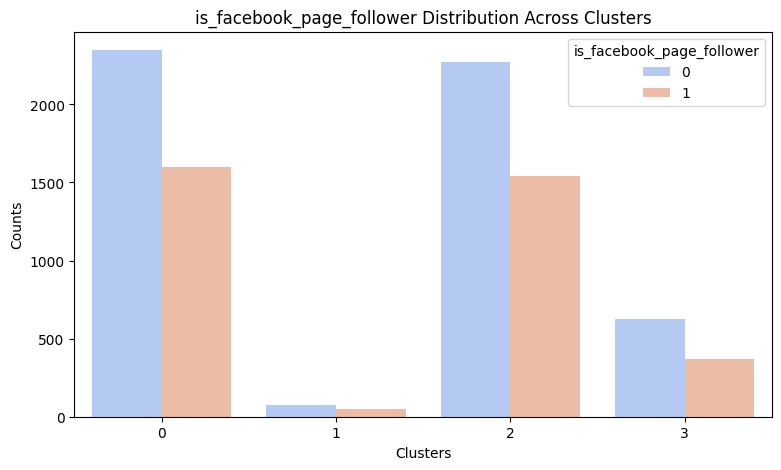

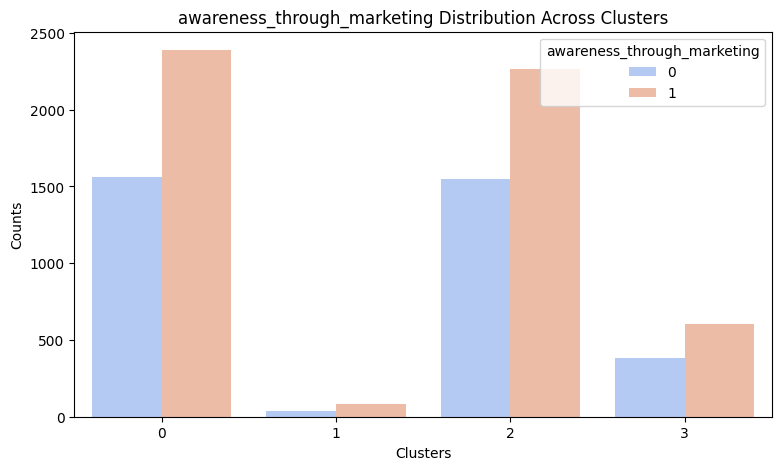

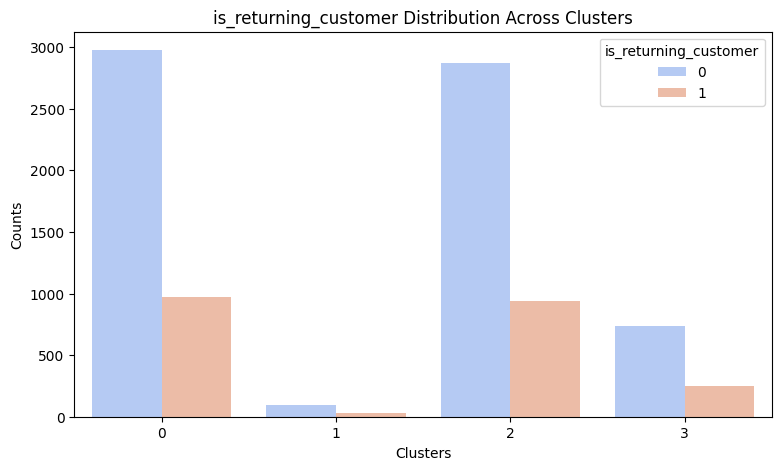

In [70]:
categorical_features = ['mobile_model','is_local', 'gender',
       'is_from_facebook_page', 'is_facebook_page_follower',
       'awareness_through_marketing',
       'is_returning_customer']

for feature in categorical_features:
  if feature == 'mobile_model':
    plt.figure(figsize=(12,8))
  else:
    plt.figure(figsize=(9,5))

  sns.countplot(data=dataset, x='cluster', hue=feature, palette='coolwarm')
  plt.title(f'{feature} Distribution Across Clusters')
  plt.xlabel('Clusters')
  plt.ylabel('Counts')
  plt.legend(title=feature)
  plt.show()